# BaseEstimator, TransformerMixin 사용자정의 함수와 파이프라인
### BaseExtimator, TranformarMxin, Class, inheritance
<img src='https://images.unsplash.com/photo-1529517986296-847580704921?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTh8fGhvbGlzdGljJTIwdmlld3xlbnwwfHwwfHw%3D&auto=format&fit=crop&w=500&q=60'>

In [1]:
# 명령 결과 모두 보기
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 버전 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 판다스와 넘피
import pandas as pd
import numpy as np

# 그림 그리기
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['axes.unicode_minus'] = False # 그래프 음수 깨짐 방지

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 


# 자료 스케일링
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 모델 선택
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# 성능지표
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

# 파이프라인
from sklearn.pipeline import Pipeline, make_pipeline

# 시각화 툴
import scikitplot as skplt

# 모델저장
from joblib import dump, load

# 1. Get the data

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='California-Housing-Prices', as_frame=True)
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
housing = pd.DataFrame(data.data, columns = data.feature_names)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# 2. Discover and visualize the data to gain insights

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

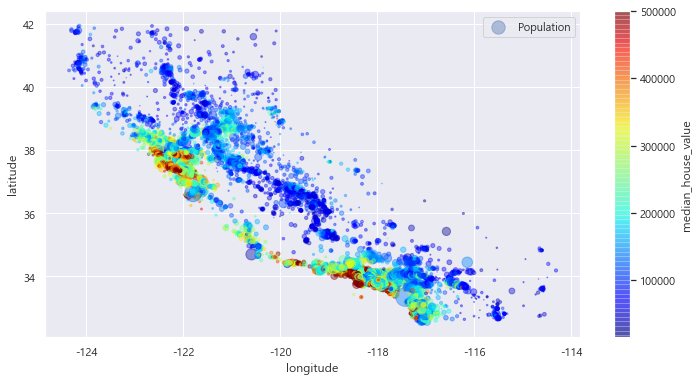

In [4]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="Population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

0.6880752079585484

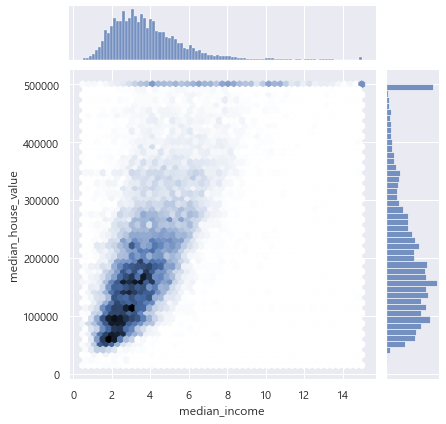

In [5]:
sns.jointplot("median_income", "median_house_value", data=housing, kind="hex")
housing.median_income.corr(housing.median_house_value)

# 3. Prepare the data for Machine Learning algorithms
## 3.1 Numerical variables with data preprocessing

In [6]:
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY


In [7]:
X = housing.drop(['longitude', 'latitude', 'median_house_value'], axis=1)
y = housing['median_house_value']
X.head(2)
y.head(2)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY


0    452600.0
1    358500.0
Name: median_house_value, dtype: float64

### BaseEstimator. TransformerMixin
- 1번째 방법 : pandas를 적용하여 변형
- TransformerMixin은 fit_tranform에 사용
       * attr_adder.transform(X) 일 경우에는 TransformerMixin 모듈 필요없음(상속도 필요없음)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 1, 2, 3, 4 # numpy의 컬럼명 지정

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder()
X_extra_attribs = attr_adder.transform(X.values) 

X_extra_attribs = pd.DataFrame(X_extra_attribs,
                               columns=list(X.columns)+["rooms_per_household", "population_per_household"],
                               index=housing.index)

X_extra_attribs.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,6.984127,2.555556
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,6.238137,2.109842
2,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,8.288136,2.80226
3,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,5.817352,2.547945
4,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,6.281853,2.181467


<AxesSubplot:>

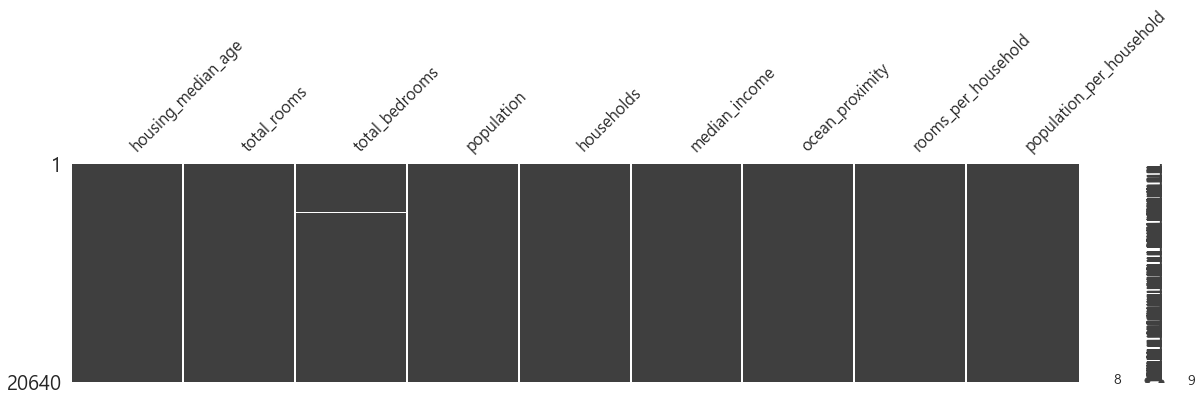

In [9]:
import missingno as msn
msn.matrix(X_extra_attribs, figsize=(20,4))

### Now let's build a pipeline for preprocessing the numerical attributes:

In [10]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

X_num = X.drop(['ocean_proximity'], axis=1)
X_num.head(2)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,41.0,880.0,129.0,322.0,126.0,8.3252
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014


In [11]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             CombinedAttributesAdder(),
                             StandardScaler()
                            )  
                 
X_num_tr = num_pipeline.fit_transform(X_num) # TransformerMixin 모듈

X_num_tr = pd.DataFrame(X_num_tr,
                        columns=list(X_num.columns)+["rooms_per_household",
                                                     "population_per_household"],
                        index=housing.index)

X_num_tr.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household
0,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.628559,-0.049597
1,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.327041,-0.092512
2,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.155620,-0.025843
3,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.156966,-0.050329
4,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.344711,-0.085616


<AxesSubplot:>

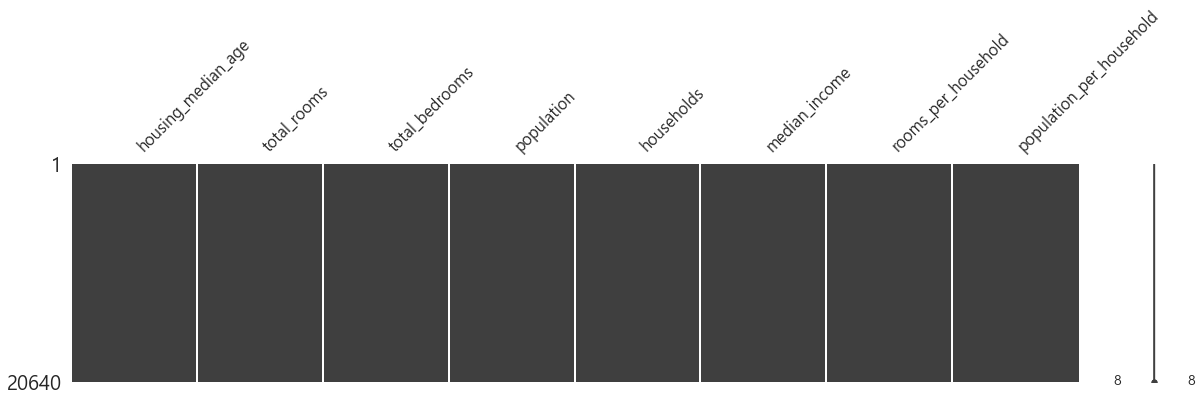

In [12]:
msn.matrix(X_num_tr, figsize=(20,4))

## 3.3 Categorical variables with data preprocessing
### Column transformers
- 수치형과 범주형 변수를 모두 차별적으로 데이터전처리하여 일괄처리

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(X_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, num_attribs),
        ("categorical", OneHotEncoder(), cat_attribs),
    ])

In [14]:
from sklearn import set_config
set_config(display="diagram")
full_pipeline  # click on the diagram below to see the details of each step

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('combinedattributesadder',
                                                  CombinedAttributesAdder()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['housing_median_age', 'total_rooms',
                                  'total_bedrooms', 'population', 'households',
                                  'median_income']),
                                ('categorical', OneHotEncoder(),
                                 ['ocean_proximity'])])

In [15]:
X_prepared = full_pipeline.fit_transform(X)
X_prepared

array([[ 0.98214266, -0.8048191 , -0.97247648, ...,  0.        ,
         1.        ,  0.        ],
       [-0.60701891,  2.0458901 ,  1.35714343, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.85618152, -0.53574589, -0.82702426, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.92485123, -0.17499526, -0.12360781, ...,  0.        ,
         0.        ,  0.        ],
       [-0.84539315, -0.35559977, -0.30482697, ...,  0.        ,
         0.        ,  0.        ],
       [-1.00430931,  0.06840827,  0.18875678, ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
full_pipeline
full_pipeline.named_transformers_
full_pipeline.named_transformers_["categorical"].categories_[0]

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('combinedattributesadder',
                                                  CombinedAttributesAdder()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['housing_median_age', 'total_rooms',
                                  'total_bedrooms', 'population', 'households',
                                  'median_income']),
                                ('categorical', OneHotEncoder(),
                                 ['ocean_proximity'])])

{'numerical': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('combinedattributesadder', CombinedAttributesAdder()),
                 ('standardscaler', StandardScaler())]),
 'categorical': OneHotEncoder()}

array(['1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

# 4. Learning and predicting

In [17]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

grid_search = RandomizedSearchCV(forest_reg, param_grid, cv=5, 
                                 scoring='neg_mean_squared_error')

grid_search.fit(X_prepared, y)
grid_search.best_estimator_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions=[{'max_features': [2, 4, 6, 8],
                                         'n_estimators': [3, 10, 30]},
                                        {'bootstrap': [False],
                                         'max_features': [2, 3, 4],
                                         'n_estimators': [3, 10]}],
                   scoring='neg_mean_squared_error')

RandomForestRegressor(max_features=8, n_estimators=30)

In [18]:
grid_search.best_params_

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'n_estimators': 30, 'max_features': 8}

74994.01194449003 {'n_estimators': 3, 'max_features': 6}
67269.05511867996 {'n_estimators': 30, 'max_features': 8}
70765.96902048931 {'n_estimators': 10, 'max_features': 3, 'bootstrap': False}
72728.55008510184 {'n_estimators': 10, 'max_features': 2}
76863.61826004356 {'n_estimators': 3, 'max_features': 4, 'bootstrap': False}
68815.00658184181 {'n_estimators': 10, 'max_features': 4}
69988.93044742128 {'n_estimators': 30, 'max_features': 2}
80053.47323381568 {'n_estimators': 3, 'max_features': 2, 'bootstrap': False}
78038.97595472199 {'n_estimators': 3, 'max_features': 3, 'bootstrap': False}
70155.82934256335 {'n_estimators': 10, 'max_features': 4, 'bootstrap': False}


In [19]:
best_params = grid_search.best_params_
tuned_params = {item[:]: best_params[item] for item in best_params}
model= RandomForestRegressor().set_params(**tuned_params)
model.fit(X_prepared, y)

RandomForestRegressor(max_features=8, n_estimators=30)

In [20]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["categorical"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(model.feature_importances_, attributes), reverse=True)

[(0.45154423165351915, 'median_income'),
 (0.15562334030975886, '1H OCEAN'),
 (0.1381697722759215, 'pop_per_hhold'),
 (0.06822081807423748, 'rooms_per_hhold'),
 (0.061959287981430376, 'housing_median_age'),
 (0.02870364520043762, 'total_bedrooms'),
 (0.027323204370211896, 'total_rooms'),
 (0.026568590798806236, 'population'),
 (0.024891609583218382, 'households'),
 (0.007995043136366873, 'bedrooms_per_room'),
 (0.004404027703219637, 'NEAR BAY'),
 (0.004109155055471989, 'ISLAND'),
 (0.0004872738574000342, 'INLAND')]

<BarContainer object of 13 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

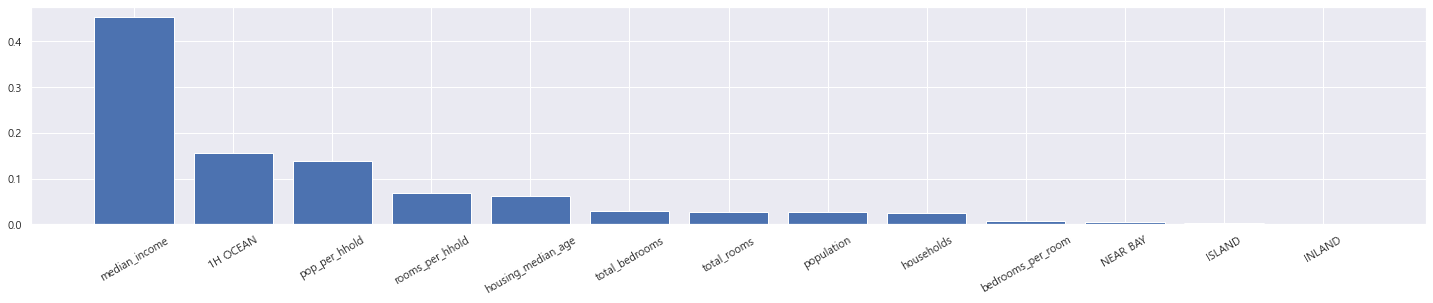

In [21]:
im = dict(sorted(zip(model.feature_importances_, attributes), reverse=True))
plt.rcParams['figure.figsize'] = [25, 4]
plt.bar(list(im.values()), list(im.keys()), align='center')
plt.xticks(rotation=30)

# End

## 8. PyCaret

In [22]:
from pycaret.datasets import get_data
diabetes = get_data('diabetes')
diabetes.shape

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


(768, 9)

In [30]:
from pycaret.classification import *
clf1 = setup(data = diabetes, target = 'Class variable', silent=True)

,Description,Value
0,session_id,1958
1,Target,Class variable
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(768, 9)"
5,Missing Values,0
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,0
9,High Cardinality Features,0


In [24]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7692,0.8154,0.5839,0.7011,0.6328,0.4683,0.4750,0.0440
catboost,CatBoost Classifier,0.7692,0.8174,0.6061,0.6925,0.6383,0.4727,0.4800,0.6290
lr,Logistic Regression,0.7654,0.8027,0.5570,0.7065,0.6166,0.4536,0.4630,0.6210
ridge,Ridge Classifier,0.7617,0.0000,0.5623,0.6977,0.6173,0.4489,0.4573,0.0030
ada,Ada Boost Classifier,0.7617,0.7885,0.5784,0.6906,0.6265,0.4544,0.4601,0.0160
lda,Linear Discriminant Analysis,0.7599,0.8023,0.5570,0.6960,0.6135,0.4441,0.4527,0.0040
gbc,Gradient Boosting Classifier,0.7468,0.7936,0.5675,0.6704,0.6079,0.4239,0.4320,0.0170
knn,K Neighbors Classifier,0.7357,0.7510,0.5415,0.6409,0.5821,0.3931,0.3987,0.2700
xgboost,Extreme Gradient Boosting,0.7339,0.7768,0.5678,0.6276,0.5951,0.3983,0.4000,0.0690
lightgbm,Light Gradient Boosting Machine,0.7299,0.7934,0.5406,0.6312,0.5799,0.3837,0.3876,0.1470


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=4363, verbose=0,
                       warm_start=False)

In [25]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7222,0.7519,0.3158,0.7500,0.4444,0.2981,0.3477
1,0.8333,0.9188,0.7368,0.7778,0.7568,0.6301,0.6307
2,0.7778,0.8105,0.5263,0.7692,0.6250,0.4749,0.4921
3,0.7963,0.8000,0.6316,0.7500,0.6857,0.5367,0.5410
4,0.7222,0.7353,0.5263,0.6250,0.5714,0.3682,0.3711
5,0.6667,0.6361,0.3684,0.5385,0.4375,0.2123,0.2200
6,0.7963,0.8647,0.6316,0.7500,0.6857,0.5367,0.5410
7,0.7736,0.8508,0.6111,0.6875,0.6471,0.4812,0.4830
8,0.8113,0.8587,0.6667,0.7500,0.7059,0.5677,0.5698
9,0.7547,0.8000,0.5556,0.6667,0.6061,0.4301,0.4339


In [26]:
tunes_lr = tune_model(lr)
tunes_lr

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7222,0.7564,0.3158,0.7500,0.4444,0.2981,0.3477
1,0.8333,0.9308,0.7368,0.7778,0.7568,0.6301,0.6307
2,0.7593,0.8195,0.5789,0.6875,0.6286,0.4524,0.4561
3,0.7778,0.8150,0.6316,0.7059,0.6667,0.5008,0.5025
4,0.7407,0.7504,0.5263,0.6667,0.5882,0.4028,0.4088
5,0.6852,0.6451,0.4211,0.5714,0.4848,0.2656,0.2720
6,0.7963,0.8662,0.6316,0.7500,0.6857,0.5367,0.5410
7,0.7925,0.8635,0.6111,0.7333,0.6667,0.5178,0.5223
8,0.8302,0.8556,0.6667,0.8000,0.7273,0.6055,0.6108
9,0.7547,0.8048,0.5556,0.6667,0.6061,0.4301,0.4339


LogisticRegression(C=0.228, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4363, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
evaluate_model(lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [28]:
pred_holdout = predict_model(lr)
pred_holdout.shape
pred_holdout.iloc[:, 20:27]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7662,0.8314,0.5556,0.7143,0.6250,0.4590,0.4667


(231, 27)

,Number of times pregnant_6,Number of times pregnant_7,Number of times pregnant_8,Number of times pregnant_9,Class variable,Label,Score
0,0.0,0.0,0.0,0.0,1,1,0.8846
1,0.0,0.0,0.0,0.0,1,0,0.5813
2,0.0,0.0,0.0,0.0,0,0,0.5704
3,0.0,0.0,0.0,0.0,0,0,0.9721
4,1.0,0.0,0.0,0.0,1,1,0.5282
...,...,...,...,...,...,...,...
226,0.0,0.0,0.0,0.0,0,0,0.9663
227,0.0,0.0,0.0,0.0,0,0,0.7194
228,0.0,0.0,0.0,0.0,0,0,0.7466
229,0.0,0.0,0.0,0.0,0,0,0.8446


In [29]:
final_lr = finalize_model(lr)
final_lr 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4363, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# End